In [1]:
from model_debug import *
import torch
import torch.nn as nn
from win_dataset import *
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchmetrics.functional import psnr, ssim, accuracy
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
model = GCANet()
model.load_state_dict(torch.load('/openbayes/home/snapshots_round2/model_30.pth'))
model = model.cuda()

In [3]:
class Args(object):
    def __init__(self):
        self.batch_size = 32
        self.num_workers = 0
        self.test_orig_images_path = '/openbayes/input/input1/clear/'
        self.test_degen_images_path = '/openbayes/input/input1/degen/'

In [4]:
def test(args, model, mode):
    model.eval()
    print('testing '+mode)
    weights_mean={}
    channel_weights_mean=np.zeros((14,1,120))
    with torch.no_grad():
        val_list = populate_test_list(args.test_orig_images_path, args.test_degen_images_path, mode)
        val_dataset = merge_dataset(val_list, train=False)
        val_dataloader = DataLoader(val_dataset, batch_size=1, num_workers=args.num_workers, shuffle=False, pin_memory=True)
        
        l = len(val_dataloader)
        for step, batch in enumerate(tqdm(val_dataloader)):
            data_orig, data_degen, label = [i.cuda() for i in batch]
            weights_dict,channel_weights = model(data_degen)
            
            channel_weights_mean+=channel_weights
            for key in weights_dict:
                if key in weights_mean.keys():
                    weights_mean[key]+=weights_dict[key]
                else:
                    weights_mean[key]=weights_dict[key]
        for key in weights_mean:
            weights_mean[key]=weights_mean[key]/l
        channel_weights_mean=channel_weights_mean/l
    return weights_mean,channel_weights_mean

In [5]:
args = Args()
hazy_o_weights,hazy_c_weights  = test(args,model,'hazy')
rain_o_weights,rain_c_weights = test(args,model,'rain')
raindrop_a_o_weights,raindrop_a_c_weights = test(args,model,'rain_drop_test_a')
raindrop_b_o_weights,raindrop_b_c_weights = test(args,model,'rain_drop_test_b')

  0%|          | 0/500 [00:00<?, ?it/s]

testing hazy
Total testing examples: 500


  0%|          | 0/1400 [00:00<?, ?it/s]

testing rain
Total testing examples: 1400


  0%|          | 0/58 [00:00<?, ?it/s]

testing rain_drop_test_a
Total testing examples: 58


  0%|          | 0/249 [00:00<?, ?it/s]

testing rain_drop_test_b
Total testing examples: 249


100%|██████████| 249/249 [01:01<00:00,  4.03it/s]


Using matplotlib backend: agg


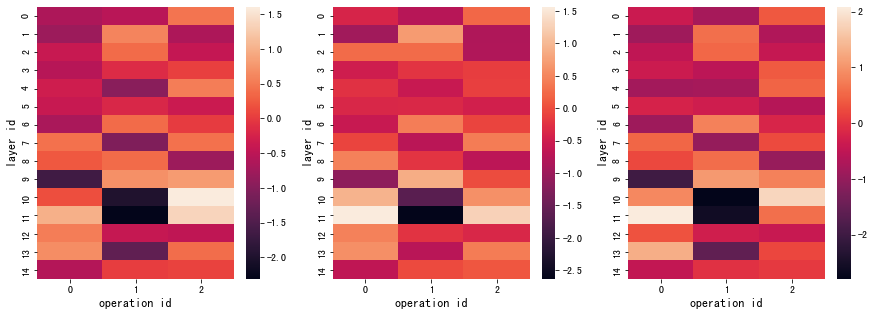

In [11]:
%matplotlib auto
plt.figure(figsize=(15,5))
hazy_ls=[]
for key in hazy_o_weights:
    length=hazy_o_weights[key].shape[1]
    for i in range(length):
        hazy_ls.append(hazy_o_weights[key][0,i,:].tolist())

plt.subplot(1,3,1)
sns.heatmap(hazy_ls)
plt.xlabel('operation id',fontsize=12)
plt.ylabel('layer id',fontsize=12)

rain_ls=[]
for key in rain_o_weights:
    length=rain_o_weights[key].shape[1]
    for i in range(length):
        rain_ls.append(rain_o_weights[key][0,i,:].tolist())

plt.subplot(1,3,2)
sns.heatmap(rain_ls)
plt.xlabel('operation id',fontsize=12)
plt.ylabel('layer id',fontsize=12)

raindrop_a_ls=[]
for key in raindrop_a_o_weights:
    length=raindrop_a_o_weights[key].shape[1]
    for i in range(length):
        raindrop_a_ls.append(raindrop_a_o_weights[key][0,i,:].tolist())

plt.subplot(1,3,3)
sns.heatmap(raindrop_a_ls)
plt.xlabel('operation id',fontsize=12)
plt.ylabel('layer id',fontsize=12)

plt.savefig('fig1.png')

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.heatmap(hazy_c_weights[:,0,:])
plt.xlabel('channel id',fontsize=12)
plt.ylabel('layer id',fontsize=12)
plt.subplot(1,3,2)
sns.heatmap(rain_c_weights[:,0,:])
plt.xlabel('channel id',fontsize=12)
plt.ylabel('layer id',fontsize=12)
plt.subplot(1,3,3)
sns.heatmap(raindrop_a_c_weights[:,0,:])
plt.xlabel('channel id',fontsize=12)
plt.ylabel('layer id',fontsize=12)
plt.savefig('fig2.png')

In [ ]:
plt.subplots(4,1,figsize=(5,20))
for i,debuger in enumerate([hazy_debuger,rain_debuger,raindrop_a_debuger,raindrop_b_debuger]):
    res1_1_attns = torch.vstack([i.squeeze() for i in debuger.attns_dict['res1_1']])
    plt.subplot(4,1,i+1)
    sns.heatmap(res1_1_attns)

In [ ]:
plt.subplots(4,1,figsize=(5,20))
for i,debuger in enumerate([hazy_debuger,rain_debuger,raindrop_a_debuger,raindrop_b_debuger]):
    res6_1_attns = torch.vstack([i.squeeze() for i in debuger.attns_dict['res6_1']])
    plt.subplot(4,1,i+1)
    sns.heatmap(res6_1_attns)

In [ ]:
plt.subplots(4,1,figsize=(5,20))
for i,debuger in enumerate([hazy_debuger,rain_debuger,raindrop_a_debuger,raindrop_b_debuger]):
    res1_1_means = torch.vstack([i.squeeze() for i in debuger.INs_dict['mean']['res1_1']])
    plt.subplot(4,1,i+1)
    sns.heatmap(res1_1_means)

In [ ]:
plt.subplots(4,1,figsize=(5,20))
for i,debuger in enumerate([hazy_debuger,rain_debuger,raindrop_a_debuger,raindrop_b_debuger]):
    res6_1_means = torch.vstack([i.squeeze() for i in debuger.INs_dict['mean']['res6_1']])
    plt.subplot(4,1,i+1)
    sns.heatmap(res6_1_means)

In [1]:
import pstats
p=pstats.Stats('result.out')
p.print_stats()
p.sort_stats('calls').print_stats()
p.sort_stats('cumulative').print_stats()

Tue Jun  1 16:02:00 2021    result.out

         3180283 function calls (3113867 primitive calls) in 88.821 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        9    0.002    0.000    0.002    0.000 {method 'readlines' of '_io._IOBase' objects}
        1    0.000    0.000    0.000    0.000 {method 'send' of 'generator' objects}
       57    0.000    0.000    0.000    0.000 {method 'decode' of 'bytes' objects}
        2    0.000    0.000    0.000    0.000 {built-in method maketrans}
        1    0.000    0.000    0.000    0.000 {method 'rfind' of 'bytes' objects}
        1    0.000    0.000    0.000    0.000 {method 'rstrip' of 'bytes' objects}
        9    0.000    0.000    0.000    0.000 {method 'startswith' of 'bytes' objects}
     1942    0.001    0.000    0.001    0.000 {method 'find' of 'bytearray' objects}
       86    0.000    0.000    0.000    0.000 {method 'translate' of 'bytearray' objects}
        1    0.0